In [1]:
import tensorflow as tf
import numpy as np
import h5py
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
train_file_path = './datasets/train_catvnoncat.h5'
test_file_path = './datasets/test_catvnoncat.h5'

In [3]:
def load_data(train_file_path, test_file_path):
    
    train = h5py.File(train_file_path)
    test = h5py.File(test_file_path)
    
    train_x_orig = train['train_set_x'].value
    train_y_orig = train['train_set_y'].value
    
    class_list = train['list_classes']
    
    test_x_orig = test['test_set_x'].value
    test_y_orig = test['test_set_y'].value
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, class_list

### Using CNN

    w_1:       [11,11,3,96] 
            
                kernel_size = (11,11)
                channel = 3
                number of filetrs = 96

In [4]:
## Load data
train_x_orig, train_y_orig, test_x_orig, test_y_orig, class_list = load_data(train_file_path,test_file_path)

In [5]:
### Shape of train and test 
print("Train :", train_x_orig.shape, train_y_orig.shape)
print("Test :", test_x_orig.shape, test_y_orig.shape)

Train : (209, 64, 64, 3) (209,)
Test : (50, 64, 64, 3) (50,)


In [6]:
train_x = train_x_orig.copy()
train_y = tf.keras.utils.to_categorical(train_y_orig)

test_x = test_x_orig.copy()
test_y = tf.keras.utils.to_categorical(test_y_orig)

In [7]:
### Shape of train and test 
print("Train :", train_x.shape, train_y.shape)
print("Test :", test_x.shape, test_y.shape)

Train : (209, 64, 64, 3) (209, 2)
Test : (50, 64, 64, 3) (50, 2)


In [8]:
### Normalizing the inputs
train_x = train_x/255.0
test_x = test_x/255.0

In [9]:
TRAIN_DIR = os.getcwd()
print(TRAIN_DIR) 

D:\MyData\Rough


In [10]:
#HYPERPARAMETERS
# our photos are in the size of (64,64,3)
IMG_SIZE = 64
epochs = 35
step_size = 8
output_classes = 2
validating_size = 40
steps = len(train_x)
remaining = steps % step_size

### First CNN config
cnn_params = {
    "1":{
        
        ## weight params
        "kernel_size":(11,11),
        "channel": 3,
        "num_of_filters": 96,
        
        ## cnn param
        "conv_strides":(4,4),
        "conv_padding":"VALID",
        
        ## max pool param
        "max_pool_ksize": (3,3),
        "max_pool_stride":(2,2),
        "max_pool_padding":"VALID",
        
    },
    
    "2":{
        
        ## weight params
        "kernel_size":(5,5),
        "channel": 96,
        "num_of_filters": 256,
        
        ## cnn param
        "conv_strides":(1,1),
        "conv_padding":"SAME",
        
        ## max pool param
        "max_pool_ksize": (3,3),
        "max_pool_stride":(2,2),
        "max_pool_padding":"VALID",
        
    },
    
    "flat_layer_1": {
        "number_of_units": 256,
        "dropout": 0.5 
    },
    
    "flat_layer_2": {
        "number_of_units": 512,
        "dropout": 0.5 
    }
}

In [11]:
def get_weight_params(cnn_params, level = None):
    w_config = list(cnn_params[level]["kernel_size"])+ [cnn_params[level]["channel"]] + [cnn_params[level]["num_of_filters"]]
    b_config = [cnn_params[level]["num_of_filters"]]
    return  w_config, b_config

In [12]:
def get_cnn_param(cnn_params, level = None):
    
    strides = [1] + list(cnn_params[level]["conv_strides"]) + [1]
    padding = cnn_params[level]["conv_padding"]
    
    return strides, padding

In [13]:
def get_max_pool_param(cnn_params, level = None):
    ksize = [1] + list(cnn_params[level]["max_pool_ksize"]) + [1]
    strides = [1] + list(cnn_params[level]["max_pool_stride"]) + [1]
    padding = cnn_params[level]["max_pool_padding"]
    
    return ksize, strides, padding

In [14]:
#Resetting graph
tf.reset_default_graph()

#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE,IMG_SIZE,3],name = 'x')
y_true = tf.placeholder(tf.float32,shape=[None,output_classes],name = 'y_true')

In [15]:
##CONVOLUTION LAYER 1
w_1_param,b_1_param = get_weight_params(cnn_params, "1")
cnn_strides, cnn_padding = get_cnn_param(cnn_params,"1")
ksize, strides, padding = get_max_pool_param(cnn_params,"1")

#Weights for layer 1
w_1 = tf.Variable(tf.truncated_normal(w_1_param, stddev=0.01))
b_1 = tf.Variable(tf.constant(0.0, shape=b_1_param))
c_1 = tf.nn.conv2d(x, w_1,strides= cnn_strides, padding=cnn_padding)
c_1 = c_1 + b_1
c_1 = tf.nn.relu(c_1)
p_1 = tf.nn.max_pool(c_1, ksize=ksize,strides=strides, padding=padding)
print(p_1)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("MaxPool:0", shape=(?, 6, 6, 96), dtype=float32)


In [16]:
##CONVOLUTION LAYER 2
w_2_param,b_2_param = get_weight_params(cnn_params, "2")
cnn_strides, cnn_padding = get_cnn_param(cnn_params,"2")
ksize, strides, padding = get_max_pool_param(cnn_params,"2")

#Weights for layer 1
w_2 = tf.Variable(tf.truncated_normal(w_2_param, stddev=0.01))
b_2 = tf.Variable(tf.constant(0.0, shape=b_2_param))
c_2 = tf.nn.conv2d(p_1, w_2,strides= cnn_strides, padding=cnn_padding)
c_2 = c_2 + b_2
c_2 = tf.nn.relu(c_2)
p_2 = tf.nn.max_pool(c_2, ksize=ksize,strides=strides, padding=padding)
print(p_2)

Tensor("MaxPool_1:0", shape=(?, 2, 2, 256), dtype=float32)


In [17]:
#Flattening
flattened = tf.reshape(p_2,[-1,p_2.shape[1] * p_2.shape[2] * p_2.shape[3]])
print(flattened)

Tensor("Reshape:0", shape=(?, 1024), dtype=float32)


In [18]:
##Fully Connected Layer 1
units_1 = cnn_params["flat_layer_1"]["number_of_units"]
dropout_1 = cnn_params["flat_layer_1"]["dropout"]

input_size = int( flattened.get_shape()[1] )
w1_fc = tf.Variable(tf.truncated_normal([input_size, units_1], stddev=0.01))
b1_fc = tf.Variable( tf.constant(1.0, shape=[units_1] ) )
s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
s_fc1 = tf.nn.relu(s_fc1)
#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32, name = 'hold_prob1')
s_fc1 = tf.nn.dropout(s_fc1,keep_prob=dropout_1)

print(s_fc1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/mul:0", shape=(?, 256), dtype=float32)


In [19]:
##Fully Connected Layer 2
units_2 = cnn_params["flat_layer_2"]["number_of_units"]
dropout_2 = cnn_params["flat_layer_2"]["dropout"]

w2_fc = tf.Variable(tf.truncated_normal([units_1, units_2], stddev=0.01))
b2_fc = tf.Variable( tf.constant(1.0, shape=[units_2] ) )
s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
s_fc2 = tf.nn.relu(s_fc2)
#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32,name = 'hold_prob2')
s_fc2 = tf.nn.dropout(s_fc2,keep_prob=dropout_2)
print(s_fc2)

Tensor("dropout_1/mul:0", shape=(?, 512), dtype=float32)


In [20]:
##Fully Connected Layer 3
#Weights for FC Layer 3
w3_fc = tf.Variable(tf.truncated_normal([units_2,output_classes], stddev=0.01))
b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
y_pred = tf.matmul(s_fc2, w3_fc) + b3_fc
#Applying RELU
print(y_pred)

Tensor("add_4:0", shape=(?, 2), dtype=float32)


In [21]:
#Defining loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

#Defining objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)

In [22]:
#Defining Accuracy
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [23]:
#Initializing weights
init = tf.global_variables_initializer()

#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []
saver = tf.train.Saver()

config = tf.ConfigProto(device_count = {'GPU': 0})

In [24]:
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(0,steps-remaining,step_size):
            #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],feed_dict={x:train_x[j:j+step_size] , y_true:train_y[j:j+step_size],hold_prob1:0.5,hold_prob2:0.5})
        
        #Writing for loop to calculate test statistics. GTX 1050 isn't able to calculate all test data.
        cv_auc_list = []
        cv_acc_list = []
        cv_loss_list = []
        for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
            acc_on_cv,loss_on_cv,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],feed_dict={x:test_x[v:v+validating_size] ,y_true:test_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
            auc_on_cv = roc_auc_score(test_y[v:v+validating_size],preds)
            cv_acc_list.append(acc_on_cv)
            cv_auc_list.append(auc_on_cv)
            cv_loss_list.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc_list),5)
        auc_cv_ = round(np.mean(cv_auc_list),5)
        loss_cv_ = round(np.mean(cv_loss_list),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("Epoch:",i,"Accuracy:",acc_cv_,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
    
    test_auc_list = []
    test_acc_list = []
    test_loss_list = []
    
    for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
        acc_on_test,loss_on_test,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],feed_dict={x:test_x[v:v+validating_size] ,
        y_true:test_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
        auc_on_test = roc_auc_score(test_y[v:v+validating_size],preds)
        test_acc_list.append(acc_on_test)
        test_auc_list.append(auc_on_test)
        test_loss_list.append(loss_on_test)
    saver.save(sess, os.path.join(os.getcwd(),"CNN_MC.ckpt"))
    
    test_acc_ = round(np.mean(test_acc_list),5)
    test_auc_ = round(np.mean(test_auc_list),5)
    test_loss_ = round(np.mean(test_loss_list),5)
    print("Test Results are below:")
    print("Accuracy:",test_acc_,"Loss:",test_loss_,"AUC:",test_auc_)

Epoch: 0 Accuracy: 0.375 Loss: 0.75279 AUC: 0.52137
Epoch: 1 Accuracy: 0.35 Loss: 0.81471 AUC: 0.40171
Epoch: 2 Accuracy: 0.375 Loss: 0.85446 AUC: 0.46724
Epoch: 3 Accuracy: 0.35 Loss: 0.87887 AUC: 0.39031
Epoch: 4 Accuracy: 0.275 Loss: 0.883 AUC: 0.34473
Epoch: 5 Accuracy: 0.325 Loss: 0.8626 AUC: 0.46724
Epoch: 6 Accuracy: 0.3 Loss: 0.87422 AUC: 0.40171
Epoch: 7 Accuracy: 0.3 Loss: 0.86768 AUC: 0.4416
Epoch: 8 Accuracy: 0.325 Loss: 0.87305 AUC: 0.47863
Epoch: 9 Accuracy: 0.325 Loss: 0.87049 AUC: 0.4359
Epoch: 10 Accuracy: 0.325 Loss: 0.86994 AUC: 0.49288
Epoch: 11 Accuracy: 0.325 Loss: 0.88153 AUC: 0.49003
Epoch: 12 Accuracy: 0.325 Loss: 0.86279 AUC: 0.52137
Epoch: 13 Accuracy: 0.325 Loss: 0.90433 AUC: 0.36182
Epoch: 14 Accuracy: 0.325 Loss: 0.87334 AUC: 0.52707
Epoch: 15 Accuracy: 0.35 Loss: 0.82542 AUC: 0.49288
Epoch: 16 Accuracy: 0.325 Loss: 0.88742 AUC: 0.37322
Epoch: 17 Accuracy: 0.375 Loss: 0.86797 AUC: 0.48148
Epoch: 18 Accuracy: 0.325 Loss: 0.87967 AUC: 0.42735
Epoch: 19 Accur

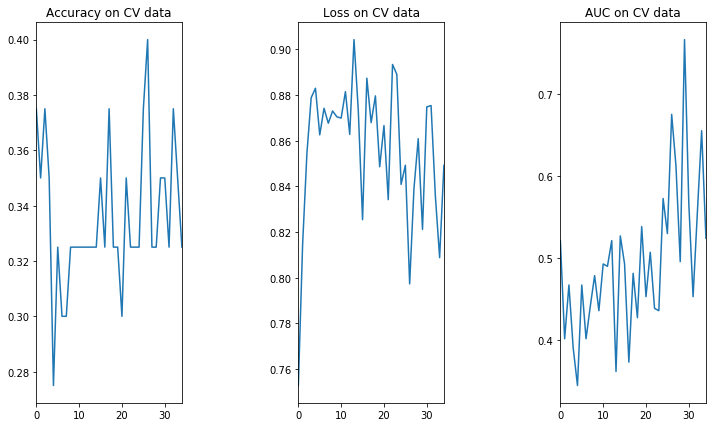

In [25]:
f,ax=plt.subplots(1,3,figsize=(12,3))
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data',ax=ax[0])
pd.Series(loss_list).plot(kind='line',figsize=(12,7),title='Loss on CV data',ax=ax[1])
pd.Series(auc_list).plot(kind='line',figsize=(12,7),title='AUC on CV data',ax=ax[2])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('Accuracy on CV data')
ax[1].set_title('Loss on CV data')
ax[2].set_title('AUC on CV data')
plt.show()

### Using standard NN

In [26]:
## Load data
train_x_orig, train_y_orig, test_x_orig, test_y_orig, class_list = load_data(train_file_path,test_file_path)

In [27]:
### Shape of train and test 
print("Train :", train_x_orig.shape, train_y_orig.shape)
print("Test :", test_x_orig.shape, test_y_orig.shape)

Train : (209, 64, 64, 3) (209,)
Test : (50, 64, 64, 3) (50,)


In [28]:
### Create feature vector
train_x = train_x_orig.reshape([train_x_orig.shape[0],-1])
train_y = tf.keras.utils.to_categorical(train_y_orig)

test_x = test_x_orig.reshape([test_x_orig.shape[0],-1])
test_y = tf.keras.utils.to_categorical(test_y_orig)

In [29]:
### Shape of train and test 
print("Train :", train_x.shape, train_y.shape)
print("Test :", test_x.shape, test_y.shape)

Train : (209, 12288) (209, 2)
Test : (50, 12288) (50, 2)


In [30]:
### Normalizing the inputs
train_x = train_x/255.0
test_x = test_x/255.0

In [31]:
### HYPERPARAMETER
IMG_SIZE = 64
EPOCHS = 30

NUM_UNITS_1 = 1024
NUM_UNITS_2 = 512
NUM_UNITS_3 = 256
OUTPUT_CLASSES = 2

In [32]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape = [None,IMG_SIZE*IMG_SIZE*3],name = 'x')
y_true = tf.placeholder(tf.float32, shape = [None,OUTPUT_CLASSES],name = 'y_true')

In [33]:
### First dense layer
w_1 = tf.Variable(tf.truncated_normal(shape = (x.shape[1].value,NUM_UNITS_1), stddev = 0.001))
b_1 = tf.Variable(tf.constant(0.0, shape = [1, NUM_UNITS_1]))
z_1 = tf.matmul(x,w_1) + b_1
a_1 = tf.nn.relu(z_1)

In [34]:
### Second dense layer
w_2 = tf.Variable(tf.truncated_normal(shape = (a_1.shape[1].value,NUM_UNITS_2), stddev = 0.001))
b_2 = tf.Variable(tf.constant(0.0, shape = [1, NUM_UNITS_2]))
z_2 = tf.matmul(a_1,w_2) + b_2
a_2 = tf.nn.relu(z_2)

In [35]:
### Third dense layer
w_3 = tf.Variable(tf.truncated_normal(shape = (a_2.shape[1].value,NUM_UNITS_3), stddev = 0.001))
b_3 = tf.Variable(tf.constant(0.0, shape = [1, NUM_UNITS_3]))
z_3 = tf.matmul(a_2,w_3) + b_3
a_3 = tf.nn.relu(z_3)

In [36]:
### OUTPUT LAYER
w_4 = tf.Variable(tf.truncated_normal(shape = (a_3.shape[1].value, OUTPUT_CLASSES), stddev = 0.001))
b_4 = tf.Variable(tf.constant(0.0, shape = [1, OUTPUT_CLASSES]))

y_pred = tf.matmul(a_3,w_4) + b_4

In [37]:
#Defining loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))
#Defining objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)

In [38]:
#Defining Accuracy
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [39]:
#Initializing weights
init = tf.global_variables_initializer()

In [40]:
#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []
saver = tf.train.Saver()

config = tf.ConfigProto(device_count = {'GPU': 0})


with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(0,steps-remaining,step_size):
            #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],feed_dict={x:train_x[j:j+step_size] , y_true:train_y[j:j+step_size]})
        
        #Writing for loop to calculate test statistics. GTX 1050 isn't able to calculate all test data.
        cv_auc_list = []
        cv_acc_list = []
        cv_loss_list = []
        for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
            acc_on_cv,loss_on_cv,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],feed_dict={x:test_x[v:v+validating_size] ,y_true:test_y[v:v+validating_size]})
            auc_on_cv = roc_auc_score(test_y[v:v+validating_size],preds)
            cv_acc_list.append(acc_on_cv)
            cv_auc_list.append(auc_on_cv)
            cv_loss_list.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc_list),5)
        auc_cv_ = round(np.mean(cv_auc_list),5)
        loss_cv_ = round(np.mean(cv_loss_list),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("Epoch:",i,"Accuracy:",acc_cv_,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
    
    test_auc_list = []
    test_acc_list = []
    test_loss_list = []
    
    for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
        acc_on_test,loss_on_test,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],feed_dict={x:test_x[v:v+validating_size] ,
        y_true:test_y[v:v+validating_size] })
        auc_on_test = roc_auc_score(test_y[v:v+validating_size],preds)
        test_acc_list.append(acc_on_test)
        test_auc_list.append(auc_on_test)
        test_loss_list.append(loss_on_test)
    saver.save(sess, os.path.join(os.getcwd(),"CNN_MC.ckpt"))
    
    test_acc_ = round(np.mean(test_acc_list),5)
    test_auc_ = round(np.mean(test_auc_list),5)
    test_loss_ = round(np.mean(test_loss_list),5)
    print("Test Results are below:")
    print("Accuracy:",test_acc_,"Loss:",test_loss_,"AUC:",test_auc_)

Epoch: 0 Accuracy: 0.325 Loss: 0.69322 AUC: 0.27635
Epoch: 1 Accuracy: 0.325 Loss: 0.69362 AUC: 0.26781
Epoch: 2 Accuracy: 0.325 Loss: 0.6974 AUC: 0.26211
Epoch: 3 Accuracy: 0.325 Loss: 0.71564 AUC: 0.26211
Epoch: 4 Accuracy: 0.325 Loss: 0.7632 AUC: 0.26211
Epoch: 5 Accuracy: 0.325 Loss: 0.82061 AUC: 0.26781
Epoch: 6 Accuracy: 0.325 Loss: 0.84849 AUC: 0.2735
Epoch: 7 Accuracy: 0.325 Loss: 0.85546 AUC: 0.2792
Epoch: 8 Accuracy: 0.325 Loss: 0.85725 AUC: 0.28205
Epoch: 9 Accuracy: 0.325 Loss: 0.85812 AUC: 0.28775
Epoch: 10 Accuracy: 0.325 Loss: 0.85875 AUC: 0.28775
Epoch: 11 Accuracy: 0.325 Loss: 0.85926 AUC: 0.2906
Epoch: 12 Accuracy: 0.325 Loss: 0.85961 AUC: 0.2906
Epoch: 13 Accuracy: 0.325 Loss: 0.8599 AUC: 0.29345
Epoch: 14 Accuracy: 0.325 Loss: 0.86003 AUC: 0.2963
Epoch: 15 Accuracy: 0.325 Loss: 0.8601 AUC: 0.30199
Epoch: 16 Accuracy: 0.325 Loss: 0.86016 AUC: 0.30484
Epoch: 17 Accuracy: 0.325 Loss: 0.86013 AUC: 0.31054
Epoch: 18 Accuracy: 0.325 Loss: 0.86003 AUC: 0.32479
Epoch: 19 Ac